# Using Y-factor method to calculate active component noise

In [1]:
import os
import glob
from os.path import join as pjoin

In [2]:
from highz_exp.fit_temperature import Y_Factor_Thermometer
from highz_exp.s_params import S_Params
from highz_exp.spec_class import Spectrum
from highz_exp import plotter

pjoin = os.path.join
pbase = os.path.basename

data_path = os.path.expanduser("~/Desktop/High-Z/SA_Measurements")
output_path = pjoin(data_path, 'Processed')
plot_path = pjoin(data_path, 'Plots')

if os.path.exists(output_path) is False:
    os.makedirs(output_path)
if os.path.exists(plot_path) is False:
    os.makedirs(plot_path)

In [3]:
# define macros
# nchannels = 4
import numpy as np

nfft = 32768
fs = 3276.8/4
fbins = np.arange(0, nfft//2)
df = fs/nfft
faxis = fbins*df
faxis_hz = faxis*1e6
freq_range = (0, 500) # MHz
y_41_5 = []
y_43 = []
for i in range(len(faxis)):
    y_41_5.append(-41.5)
    y_43.append(-43)

### Calibrated Y-Factor Method for Noise Temperature Measurement of Active Components

In [64]:
from highz_exp import load_csv
# load data for 300K-77K measurements
file_300K = pjoin(data_path, '300K.csv')
load_csv.split_csv_by_trace_name(file_300K, 
                                 header_file=pjoin(output_path, '300K_header.csv'),
                                 data_file= pjoin(output_path, '300K_data.csv'))

file_77K = pjoin(data_path, '77K.csv')
load_csv.split_csv_by_trace_name(file_77K, 
                                 header_file=pjoin(output_path, '77K_header.csv'),
                                 data_file= pjoin(output_path, '77K_data.csv'))

file_LNA = pjoin(data_path, 'LNA01_BB013.csv')
load_csv.split_csv_by_trace_name(file_LNA, 
                                 header_file=pjoin(output_path, 'LNA01_BB013_header.csv'),
                                 data_file= pjoin(output_path, 'LNA01_BB013_data.csv'))

file_ND = pjoin(data_path, 'ND01.csv')
load_csv.split_csv_by_trace_name(file_ND, 
                                 header_file=pjoin(output_path, 'ND01_header.csv'),
                                 data_file= pjoin(output_path, 'ND01_data.csv'))

Split complete:
  Header file: /Users/yuntongzhou/Desktop/High-Z/SA_Measurements/Processed/300K_header.csv (30 rows)
  Data file: /Users/yuntongzhou/Desktop/High-Z/SA_Measurements/Processed/300K_data.csv (755 rows)
Split complete:
  Header file: /Users/yuntongzhou/Desktop/High-Z/SA_Measurements/Processed/77K_header.csv (30 rows)
  Data file: /Users/yuntongzhou/Desktop/High-Z/SA_Measurements/Processed/77K_data.csv (755 rows)
Split complete:
  Header file: /Users/yuntongzhou/Desktop/High-Z/SA_Measurements/Processed/LNA01_BB013_header.csv (30 rows)
  Data file: /Users/yuntongzhou/Desktop/High-Z/SA_Measurements/Processed/LNA01_BB013_data.csv (755 rows)
Split complete:
  Header file: /Users/yuntongzhou/Desktop/High-Z/SA_Measurements/Processed/ND01_header.csv (30 rows)
  Data file: /Users/yuntongzhou/Desktop/High-Z/SA_Measurements/Processed/ND01_data.csv (755 rows)


In [65]:
traces_77K = load_csv.parse_trace_data(pjoin(output_path, '77K_data.csv'))

WEA102_77K = Spectrum(traces_77K['Trace C']['frequency'], traces_77K['Trace C']['spectrum'], name='77K load - WEA102')
WEA101_77K = Spectrum(traces_77K['Trace A']['frequency'], traces_77K['Trace A']['spectrum'], name='77K load - WEA101 + WEA102')
LNA01_77K = Spectrum(traces_77K['Trace D']['frequency'], traces_77K['Trace D']['spectrum'], name='77K load - LNA01 + WEA101 + WEA102')

traces_300K = load_csv.parse_trace_data(pjoin(output_path, '300K_data.csv'))
WEA102_300K = Spectrum(traces_300K['Trace A']['frequency'], traces_300K['Trace A']['spectrum'], name='300K load - WEA102')
WEA101_300K = Spectrum(traces_300K['Trace B']['frequency'], traces_300K['Trace B']['spectrum'], name='300K load - WEA101 + WEA102')

traces_LNA = load_csv.parse_trace_data(pjoin(output_path, 'LNA01_BB013_data.csv'))
LNA01_300K = Spectrum(traces_LNA['Trace B']['frequency'], traces_LNA['Trace B']['spectrum'], name='300K load - LNA01')
LNA01_77K = Spectrum(traces_LNA['Trace C']['frequency'], traces_LNA['Trace C']['spectrum'], name='77K load - LNA01')
LNA01_BB = Spectrum(traces_LNA['Trace D']['frequency'], traces_LNA['Trace D']['spectrum'], name='BB013 Cal - LNA01')

traces_ND = load_csv.parse_trace_data(pjoin(output_path, 'ND01_data.csv'))
ND01 = Spectrum(traces_ND['Trace A']['frequency'], traces_ND['Trace A']['spectrum'], name='300K load - ND01')
BB013 = Spectrum(traces_ND['Trace B']['frequency'], traces_ND['Trace B']['spectrum'], name='BB013 Cal - ND01')

Found 4 traces: ['Trace A', 'Trace B', 'Trace C', 'Trace D']
Column pairs: [(0, 1), (2, 3), (4, 5), (6, 7)]
'Trace Data' found at row 3
Trace 'Trace A': parsed 751 data points
Trace 'Trace B': parsed 751 data points
Trace 'Trace C': parsed 751 data points
Trace 'Trace D': parsed 751 data points
Successfully parsed 4 traces with data
Found 4 traces: ['Trace A', 'Trace B', 'Trace C', 'Trace D']
Column pairs: [(0, 1), (2, 3), (4, 5), (6, 7)]
'Trace Data' found at row 3
Trace 'Trace A': parsed 751 data points
Trace 'Trace B': parsed 751 data points
Trace 'Trace C': parsed 751 data points
Trace 'Trace D': parsed 0 data points
Successfully parsed 3 traces with data
Found 4 traces: ['Trace A', 'Trace B', 'Trace C', 'Trace D']
Column pairs: [(0, 1), (2, 3), (4, 5), (6, 7)]
'Trace Data' found at row 3
Trace 'Trace A': parsed 751 data points
Trace 'Trace B': parsed 751 data points
Trace 'Trace C': parsed 751 data points
Trace 'Trace D': parsed 751 data points
Successfully parsed 4 traces with da

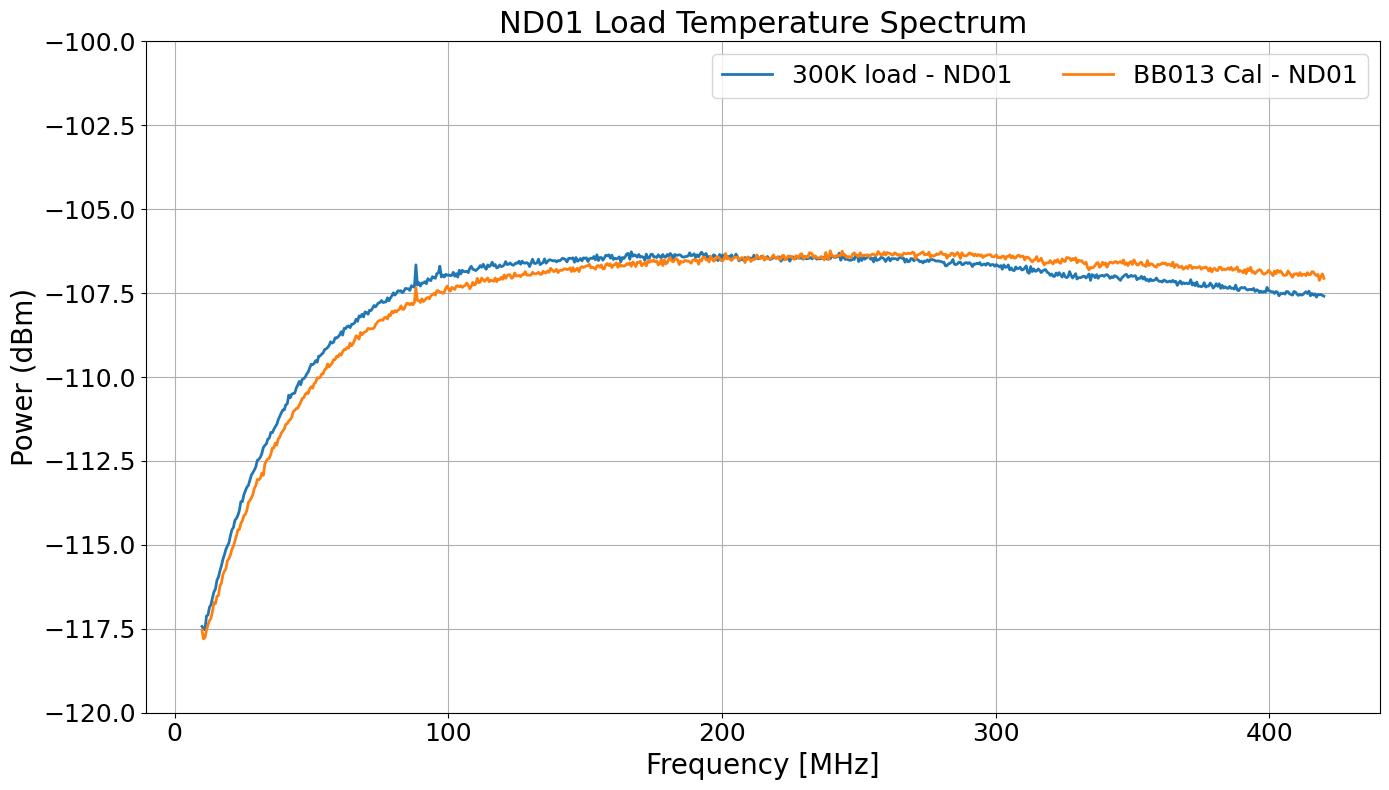

In [66]:
plotter.plot_spectrum([ND01, BB013], title='ND01 Load Temperature Spectrum', 
                      ylabel='Power (dBm)', ymax=-100, ymin=-120)

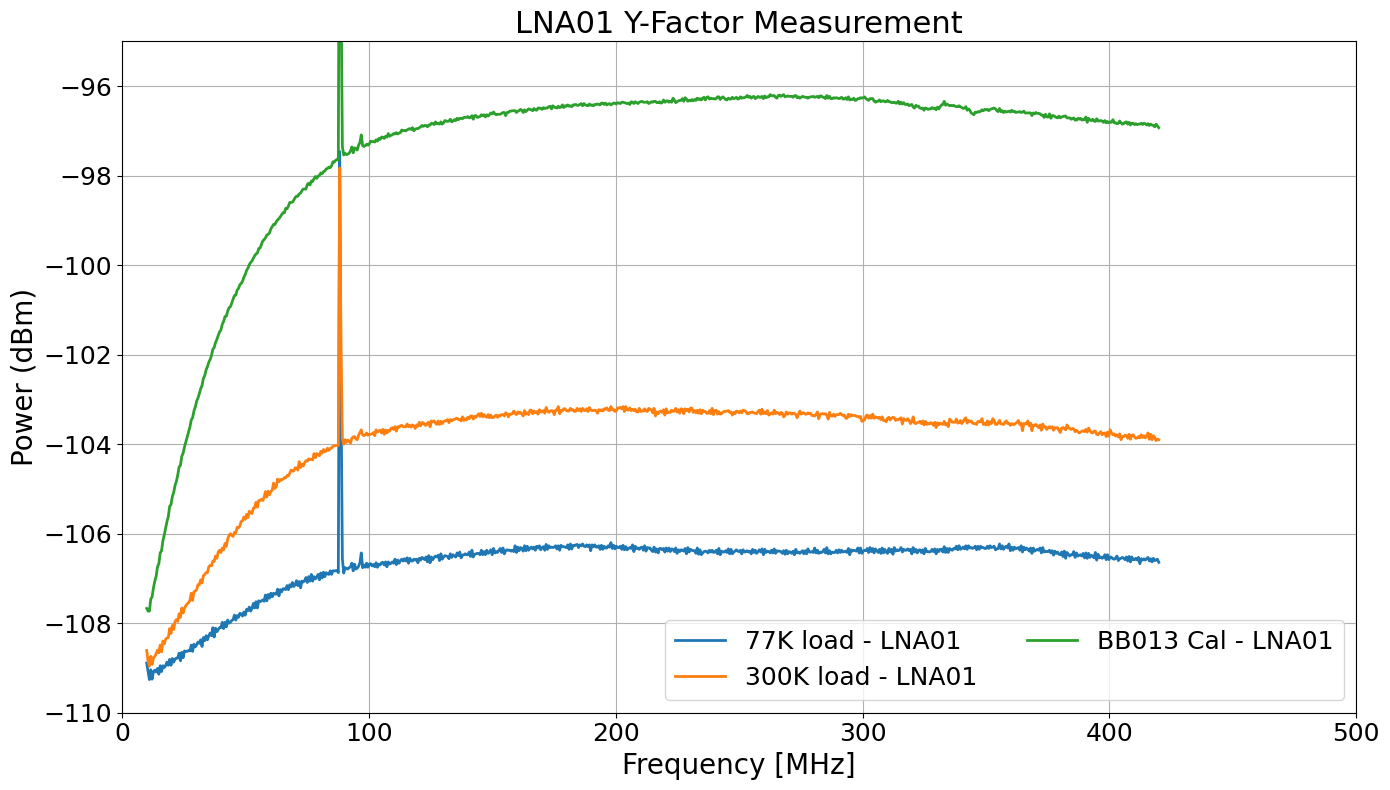

In [40]:
plotter.plot_spectrum([LNA01_77K, LNA01_300K, LNA01_BB],
                      title='LNA01 Y-Factor Measurement', 
                      ylabel='Power (dBm)', ymax=-95, ymin=-110,
                      freq_range=(0, 500),
                      save_dir=plot_path, suffix='LNA01_Y_Factor_BB013')

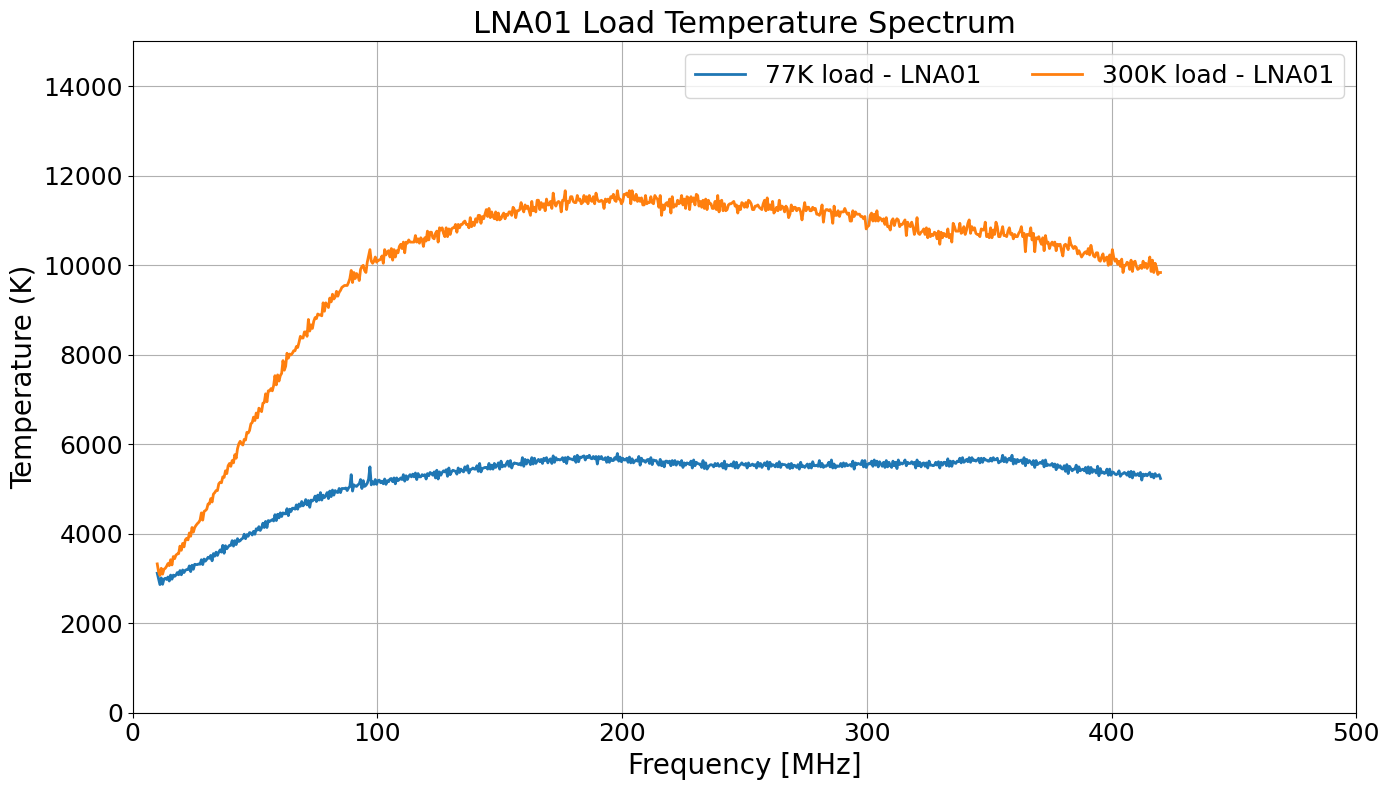

In [54]:
# plot in temperature
LNA01_77K_temp = LNA01_77K.unit_convert('dBm', 'kelvin', channel_width=300e3)
LNA01_77K_temp.despike(threshold=20)
LNA01_300K_temp = LNA01_300K.unit_convert('dBm', 'kelvin', channel_width=300e3)
LNA01_300K_temp.despike(threshold=30)
plotter.plot_spectrum([LNA01_77K_temp, LNA01_300K_temp], title='LNA01 Load Temperature Spectrum', 
                      ylabel='Temperature (K)', ymax=15000, ymin=0,
                      freq_range=(0, 500),
                      save_dir=plot_path, suffix='LNA01_Temperature_Spectrum')

In [57]:
LNA01_300K.despike(threshold=3)
LNA01_77K.despike(threshold=3)
dut_hot = LNA01_300K.unit_convert('dBm', 'milliwatt', channel_width=300e3).spec
dut_cold = LNA01_77K.unit_convert('dBm', 'milliwatt', channel_width=300e3).spec
LNA_thermo = Y_Factor_Thermometer(LNA01_300K.freq, dut_hot, dut_cold,
                                    DUT_name='LNA01', T_hot=300, T_cold=77, RBW=300e3)

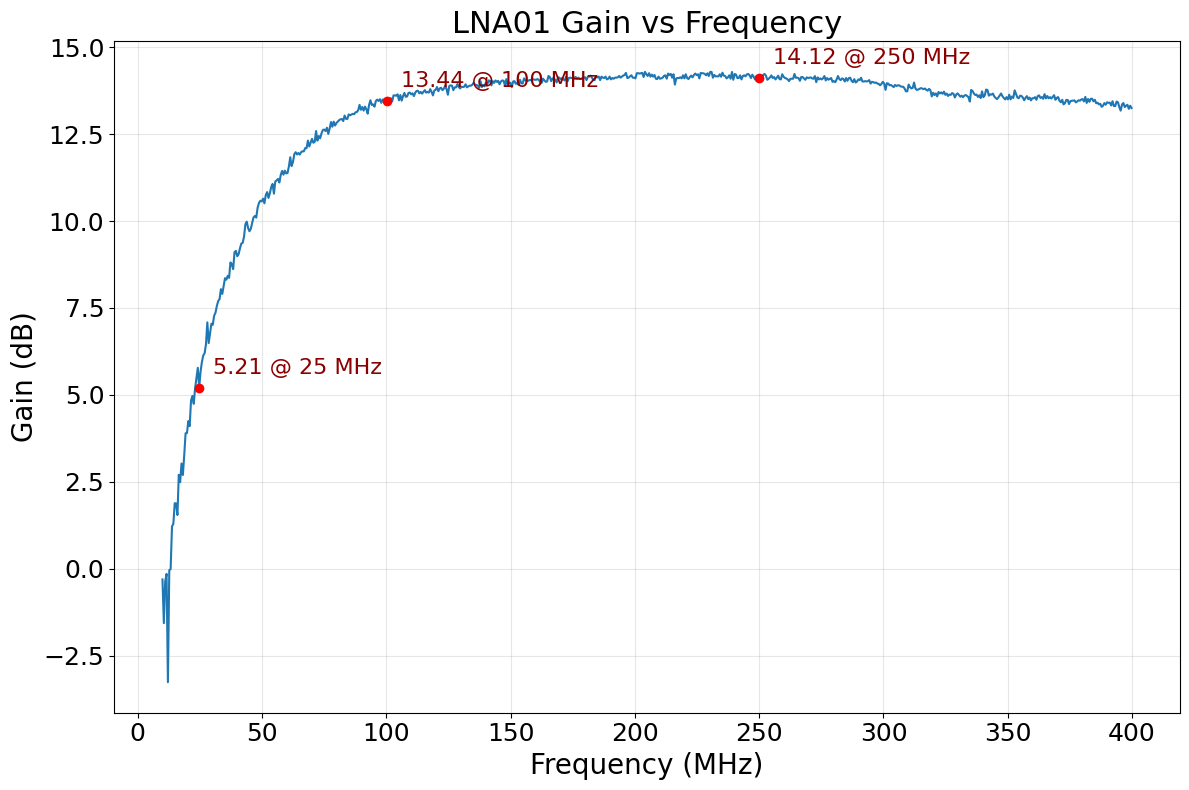

In [58]:
LNA_thermo.plot_gain(LNA_thermo.f/1e6, title='LNA01 Gain vs Frequency', ylabel='Gain (dB)',
                     marker_freqs=[25, 100, 250])

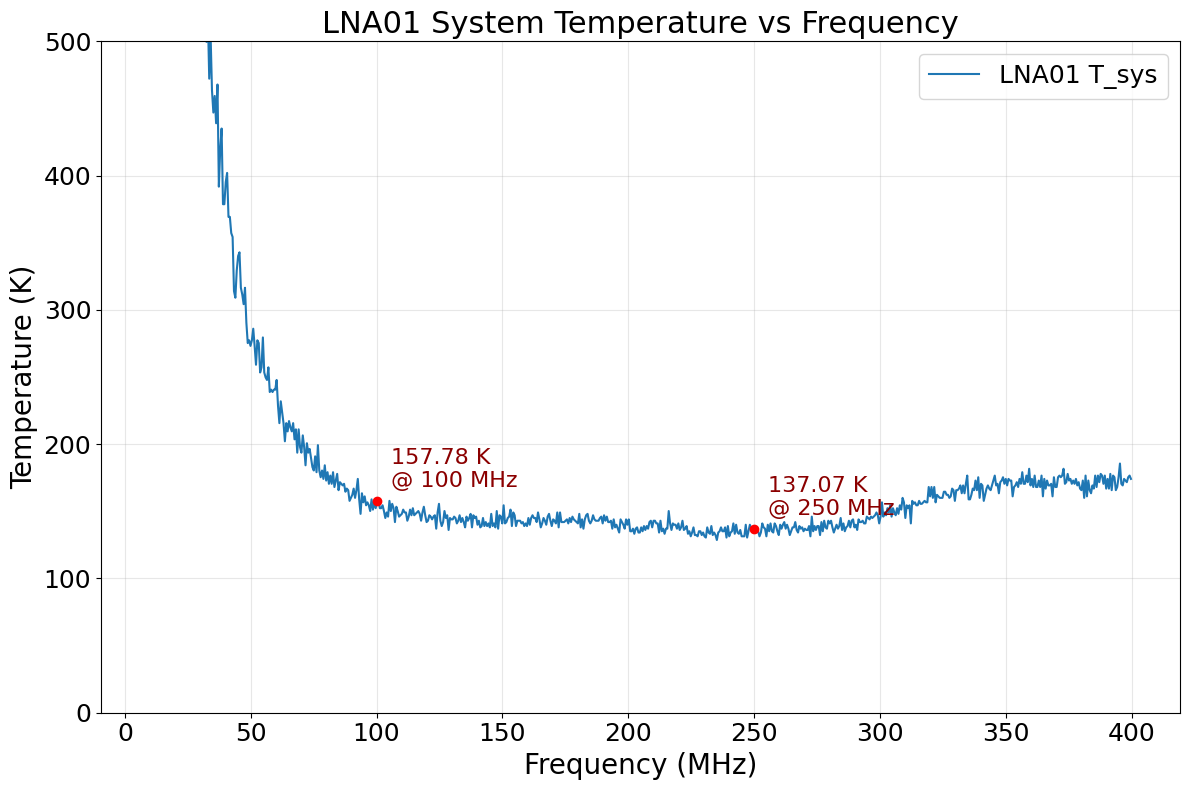

In [59]:
LNA_thermo.plot_temps(LNA_thermo.f/1e6, [LNA_thermo.T_sys], labels=['LNA01 T_sys'],
                      start_freq=10, end_freq=400, ymax=500,
                      title='LNA01 System Temperature vs Frequency',
                      ylabel='Temperature (K)',
                      marker_freqs=[25, 100, 250],
                      smoothing=False,
                      save_path=pjoin(plot_path, 'LNA01_Tsys_vs_Frequency.png'))

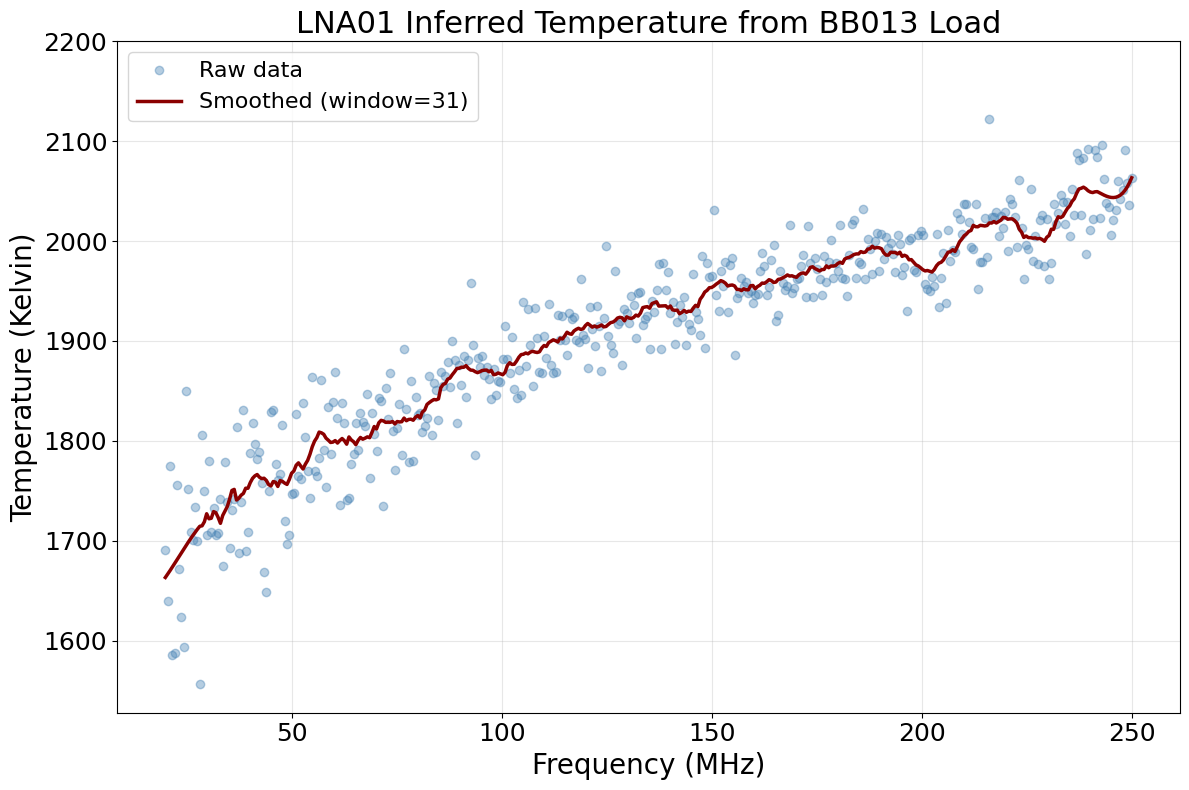

In [63]:
LNA01_BB.despike(threshold=5)
_ = LNA_thermo.infer_temperature(LNA01_BB.unit_convert('dBm', 'kelvin', channel_width=300e3, inplace=False), 
                            start_freq=20, end_freq=250, ymax=2200, ymin=1800,
                            smoothing='savgol', window_size=31,
                            title='LNA01 Inferred Temperature from BB013 Load',
                            save_path=pjoin(plot_path, 'LNA01_Inferred_Temperature_BB013.png'))